In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from pymongo import MongoClient

In [2]:
client = MongoClient("mongodb://localhost:27017/melduGrph")  # or your cloud MongoDB URI

# Access a database
db = client["melduGrph"]

# Access a collection
node_collection = db["users"]
edge_collection = db["links"]


In [3]:
G = nx.DiGraph()

In [4]:
for doc in node_collection.find():
    user_id = str(doc["_id"])  # Convert ObjectId to string for graph node
    features = {k: v for k, v in doc.items() if k != "_id"}  # Exclude _id from features if you like
    G.add_node(user_id, **features)


In [10]:
for doc in edge_collection.find():
    source = str(doc["sourceId"])
    target = str(doc["targetId"])
    
    # Extract all attributes except _id, source_id, target_id, and lesson
    attributes = {k: v for k, v in doc.items() if k not in ["_id", "sourceId", "targetId", "linkType", "lessons"]}
    
    # Add 'lesson' as the 'weight' attribute
    weight = doc.get("lessons", 1)  # default weight = 1 if missing

    # Add edge with weight and attributes
    G.add_edge(source, target, weight=weight, **attributes)

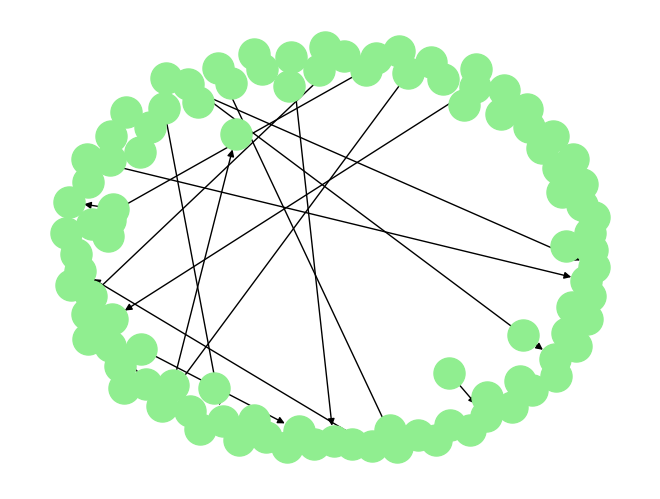

In [ ]:

# Define consistent layout
pos = nx.spring_layout(G)

# Draw graph using the same layout
nx.draw(G, pos, with_labels=False, node_color='lightgreen', node_size=500, arrows=True)

# # Combine 'type' and 'lessons' into edge labels (handle missing data safely)
# edge_labels = {
#     (u, v): f"{d.get('type', '')}, {d.get('lessons', '')} lessons"
#     for u, v, d in G.edges(data=True)
#     if 'type' in d and 'lessons' in d
# }


# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

In [ ]:
def new_connection(own_id, new_target_id, type):
    if G.has_edge(own_id, new_target_id):
        print('Edge alredy exists')
        return
    
    G.add_edge(own_id, new_target_id, weight=0, type=type)
    print('New Edge Added')

def remove_connection(own_id, target_id):
    if G.has_edge(own_id, target_id):
        G.remove_edge(own_id, target_id)

    if G.has_edge(target_id, own_id):
        G.remove_edge(target_id, own_id)
    

In [2]:


def initialize():
    client = MongoClient("mongodb://localhost:27017/meldu")  # or your cloud MongoDB URI

    # Access a database
    db = client["meldu"]

    # Access a collection
    node_collection = db["users"]
    edge_collection = db["links"]

    G = nx.DiGraph()

    for doc in node_collection.find():
        user_id = str(doc["_id"])  # Convert ObjectId to string for graph node
        features = {k: v for k, v in doc.items() if k != "_id"}  # Exclude _id from features if you like
        G.add_node(user_id, **features)

    for doc in edge_collection.find():
        source = str(doc["sourceId"])
        target = str(doc["targetId"])
        
        # Extract all attributes except _id, source_id, target_id, and lesson
        attributes = {k: v for k, v in doc.items() if k not in ["_id", "sourceId", "targetId", "lessons"]}
        
        # Add 'lesson' as the 'weight' attribute
        weight = doc.get("lessons", 1)  # default weight = 1 if missing

        # Add edge with weight and attributes
        G.add_edge(source, target, weight=weight, **attributes)

    return G


In [3]:
from torch_geometric.data import Data

import torch
import torch.nn as nn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np



In [6]:

def initialize():
    client = MongoClient("mongodb://localhost:27017/melduGrph")  # or your cloud MongoDB URI

    # Access a database
    db = client["melduGrph"]

    # Access a collection
    node_collection = db["users"]
    edge_collection = db["links"]

    G = nx.DiGraph()

    for doc in node_collection.find():
        user_id = str(doc["_id"])  # Convert ObjectId to string for graph node
        features = {k: v for k, v in doc.items() if k != "_id"}  # Exclude _id from features if you like
        G.add_node(user_id, **features)

    for doc in edge_collection.find():
        source = str(doc["sourceId"])
        target = str(doc["targetId"])
        
        # Extract all attributes except _id, source_id, target_id, and lesson
        attributes = {k: v for k, v in doc.items() if k not in ["_id", "sourceId", "targetId", "linkType", "lessons"]}
        
        # Add 'lesson' as the 'weight' attribute
        weight = doc.get("lessons", 1)  # default weight = 1 if missing

        # Add edge with weight and attributes
        G.add_edge(source, target, weight=weight, **attributes)

    return G

In [4]:
graph = initialize()

In [5]:
def process_graph(graph):
    # Predefine in order to collect unique values
    langs = set()
    interests = set()
    skills = set()
    nations = set()
    school = set()

    exprs = set()

    # Get the nodes' and edges' info from the graph
    nodes = graph.nodes(data=True)
    edges = graph.edges(data=True)

    gpas = []

    for node_id, node_attrs in nodes:
        langs.update(node_attrs.get('languages', []))
        interests.update(node_attrs.get('interests', []))
        skills.update(node_attrs.get('skills', []))
        nations.add(node_attrs.get('nationality', []))
        education = node_attrs.get('education', [])
        exprs.update(node_attrs.get('experience', []))
        
        if education:
            gpa_val = education[0].get('GPA', None)
            if gpa_val is not None:
                gpas.append(gpa_val)
            school.add(education[0].get('name', []))
        

    langs = list(langs) #50
    interests = list(interests) #33
    skills = list(skills) #21
    nations = list(nations) #25
    # schools = list(schools) #27
    schools = list(school)
    exprs = list(exprs) #10


        # Example data: map categories to unique indices
    langs_map = {lang: idx for idx, lang in enumerate(langs)}  # {'English': 0, 'French': 1, ...}
    interests_map = {interest: idx for idx, interest in enumerate(interests)}
    skills_map = {skill: idx for idx, skill in enumerate(skills)}
    nations_map = {nation: idx for idx, nation in enumerate(nations)}
    schools_map = {school: idx for idx, school in enumerate(schools)}

    exprs_map = {expr: idx for idx, expr in enumerate(exprs)}

    # Set embedding vector for each category
    language_embedding = nn.Embedding(num_embeddings=50, embedding_dim=7)
    interest_embedding = nn.Embedding(num_embeddings=33, embedding_dim=5)
    skill_embedding = nn.Embedding(num_embeddings=21, embedding_dim=4)
    nations_embedding = nn.Embedding(num_embeddings=25, embedding_dim=5)
    schools_embedding = nn.Embedding(num_embeddings=64, embedding_dim=8)
    exprs_embedding = nn.Embedding(num_embeddings=10, embedding_dim=3)

    node_features = [] #store the features of each node
    node_indx_map = {} #to fastly access any id from the tensor by the indice 

    gpa_scaler = StandardScaler()
    gpa_scaler.fit(np.array(gpas).reshape(-1, 1))

    # Initialize linear transformation to decrease the dimensions of attribute per each node
    linear_transformation = nn.Linear(33, 6)


    # Aggreagate the feature vector
    for i, (node, node_attrs) in enumerate(nodes):
   
       
        language_idx = langs_map.get(node_attrs.get('languages', [])[0], 0)  # Default to 0 if not found
        interest_idx = interests_map.get(node_attrs.get('interests', [])[0], 0)
        skill_idx = skills_map.get(node_attrs.get('skills', [])[0], 0)
        nation_idx = nations_map.get(node_attrs.get('nationality', ''), 0)

        
        education = node_attrs.get('education', [])
            
        if education:
            school_idx = schools_map.get(education[0].get('name', ''), 0)
        else:
            school_idx = 0

    
        expr_list = node_attrs.get('experience', [])
        expr_idx = exprs_map.get(expr_list[0], 0) if expr_list else 0

        lang_vec = language_embedding(torch.tensor([language_idx], dtype=torch.long)).squeeze(0)
        intr_vec = interest_embedding(torch.tensor([interest_idx], dtype=torch.long)).squeeze(0)
        skill_vec = skill_embedding(torch.tensor([skill_idx], dtype=torch.long)).squeeze(0)
        nation_vec = nations_embedding(torch.tensor([nation_idx], dtype=torch.long)).squeeze(0)
        school_vec = schools_embedding(torch.tensor([school_idx], dtype=torch.long)).squeeze(0)
        
        expr_vec = exprs_embedding(torch.tensor([expr_idx], dtype=torch.long)).squeeze(0)

        gpa_val = 0.0
        if education and education[0].get('GPA', None) is not None:
            gpa_val = education[0]['GPA']
        gpa_norm = gpa_scaler.transform(np.array([[gpa_val]]))
        gpa_vec = torch.tensor(gpa_norm[0], dtype=torch.float32)  # shape [1]


        # Join all embeding vectors along the rows and create a feature vector
        feature_vector = torch.cat([lang_vec, intr_vec, skill_vec, nation_vec, school_vec, gpa_vec, expr_vec], dim=0)


        # Apply our linear transfomation
        feature_vector = linear_transformation(feature_vector)

        node_features.append(feature_vector)

        node_id = str(node)

        node_indx_map[node_id] = i

    X = torch.stack(node_features)


    edge_index = [] #to store how our nodes are connected
    edge_attrs = [] #to store the attributes of each edge

    
    all_connType = ['Tutor', 'Student', 'Mutual'] # define unique categories of link types

    onehot = OneHotEncoder(sparse_output=False) #initialize one hot encoder for the link types
    onehot.fit(np.array(all_connType).reshape(-1, 1)) #train one hot encoder on our unique values

    scaler = StandardScaler() #initialize standard scaler

    lessons = [] #store all our lesson_num values

    for source, target, edge_attr in edges:
        lessons.append(edge_attr.get('weight', 0)) #add all our lesson values
    
    scaler.fit(np.array(lessons).reshape(-1, 1)) #train standard scaler on those values

    for source, target, edge_attr in edges:

        sourceId = str(source) #get edge source ID as a string
        targetId = str(target) #get edge target ID as a string
        source = node_indx_map[sourceId]
        target = node_indx_map[targetId]

        edge_t = onehot.transform([[edge_attr.get('linkType', 'Mutual')]]) #apply our trained one hot encoder
        edge_t_ten = torch.tensor(edge_t, dtype=torch.float32).squeeze(0) #convert to tensor and remove 1Ds

        lessons_std = scaler.transform(np.array([[edge_attr.get('weight', 0)]])) #apply our trained standard scaler
        lessons_ten = torch.tensor(lessons_std, dtype = torch.float32).squeeze(0) #convert updated values to tensor

        edge_index.append([source, target])
        edge_features = torch.cat([edge_t_ten, lessons_ten], dim=0) #concatenate our attributes tensor to one tensor along columns


        edge_attrs.append(edge_features) #append our edge attributes

    edge_index = torch.tensor(edge_index, dtype = torch.long).t().contiguous()
    edge_attrs = torch.stack(edge_attrs)

    data = Data(x=X, edge_index = edge_index, edge_attr = edge_attrs) #define our Data object
    
    

    return data, onehot, node_indx_map


In [6]:
from torch_geometric.utils import train_test_split_edges
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GCNConv as GCN
from torch_geometric.nn import NNConv
import torch.optim as optim
import pandas as pd

In [7]:
class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNModel, self).__init__()

        edge_atr_dim = 4

        # * First NNConv Layer
        edge_nn1 = nn.Sequential(
            nn.Linear(edge_atr_dim, hidden_channels * 6),
            nn.ReLU(), 
            nn.Linear(hidden_channels*6, hidden_channels*6),
            nn.ReLU(), 
            nn.Linear(hidden_channels*6, hidden_channels*6)
        )

        # * Second NNConv Layer
        edge_nn2 = nn.Sequential(
            nn.Linear(edge_atr_dim, hidden_channels * hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels * hidden_channels, hidden_channels * hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels * hidden_channels, hidden_channels * hidden_channels)
        )

        self.conv1 = NNConv(in_channels = 6, out_channels = hidden_channels, nn = edge_nn1, aggr='mean')
        self.conv2 = NNConv(in_channels = hidden_channels, out_channels = hidden_channels, nn = edge_nn2, aggr='mean')

        self.fc_edge = nn.Linear(2 * hidden_channels + 4, out_channels) #Multiclass classification with 10 inputs and 3 outputs (2 nodes + edge attributes)


        # * Out activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x, edge_index, edge_attributes):
        
        # * 1.1) Passing inputs through the first NNConv layer
        x = self.relu( # 1.2) Passing logits through the RELU
                self.conv1(x, edge_index, edge_attributes)
            )
        
        # * 2.1) Passing new inputs from previous layers through the second NNConv layer
        x = self.relu(  # 2.2) Passing logits through the RELU
                self.conv2(x, edge_index, edge_attributes)
            )

        # * 3) Getting the nodes of prediction src => dst
        src, dst = edge_index


        # * 4) Calculating the probability of our edge to form
        edge_prob = self.sigmoid( 
            (x[src] * x[dst]).sum(dim=1, keepdim=True)
        )
        assert edge_prob.shape == (edge_index.shape[1], 1), f"Shape mism: {edge_prob.shape}"

        # * 5) Combining features of both nodes and of the edge that connects them
        combined_edge_features = torch.cat((x[src], x[dst], edge_attributes), dim=1)
        
        # * 6.1) Predict the type of edge
        edge_types = self.fc_edge(combined_edge_features) # 6.2) Applying our multiclass classifier layer
        edge_types = self.softmax(edge_types) # 6.3) Apply activation function on the logits from previous layer

        return edge_prob, edge_types, src, dst



In [8]:
 # * Input dimensions
channels = 6

# * Dimensions in hidden layers
hidden_channels = 75

# * Output dimensions
out_channels = 3 

# * 1.1) Initializing our model
model = GNNModel(channels, hidden_channels, out_channels)
optimizer = optim.Adam(model.parameters(), lr=0.01) # 1.2) Optimizer for our model

# * 2.1) Initialize loss functions
edge_loss_fn = nn.BCEWithLogitsLoss() # 2.2) Loss function for the predictions of edge formation
type_loss_fn = nn.CrossEntropyLoss() # 2.3) Loss function for the predictions of edges' types

In [9]:

def train(model, data, edge_exst, optimizer, edge_loss_fn, type_loss_fn, edge_types_gt):
    
    # * 0) Set our model to the training mode and null all previos gradients
    model.train() 
    optimizer.zero_grad()

    # * 1) Make the prediction
    edge_prob, edge_types, src, dst = model(data.x, data.edge_index, data.edge_attr) # Make prediction

    # * 2.1) Calculate error in edge prediction
    edge_loss = edge_loss_fn(edge_prob.squeeze(), edge_exst[src, dst].squeeze())

    # * 2.2) Calculate error in edge's type prediction
    edge_num_to_predict = edge_types.size(0)
    type_loss = type_loss_fn(edge_types, edge_types_gt[:edge_num_to_predict])
    
    # * 2.3) Get the total error
    total_loss = edge_loss + type_loss
    
    # * 3) Calculate the gradient of those errors
    total_loss.backward(retain_graph = True)

    # * 4) Update model's parameters based on this error and run the new epoch
    optimizer.step() 

    return total_loss.item()

@torch.no_grad()
def validate(model, data, edge_exst, edge_loss_fn, type_loss_fn, edge_types_gt):
    
    #* 1) Set the evaluation mode
    model.eval() 
    
    # * 2) Make prediction
    edge_prob, edge_types, src, dst = model(data.x, data.edge_index, data.edge_attr) 
    
    # * 3) Calculate the losses
    edge_loss = edge_loss_fn(edge_prob.squeeze(), edge_exst[src, dst].squeeze())
    type_loss = type_loss_fn(edge_types, edge_types_gt[:len(src)])
    total_loss = edge_loss + type_loss


    return total_loss.item()

In [10]:
def ground_truth(graph, num_nodes, node_indx_map):
    edge_types_gt = [] # Ground truth for the edges' types
    
    # Tensor full of zeros for the following edge formation ground truth
    edge_existence = torch.zeros((num_nodes, num_nodes), dtype=torch.float32) 

    edges = graph.edges(data=True)

    for source, target, edge_attr in edges: # Traversing all edges



        # Filling our edge type dict.
        #? Tutor = 0
        #? Student = 1
        #? Mutual = 2

        if edge_attr.get('linkType', None) == 'Tutor':
            edge_types_gt.append(0)
        if edge_attr.get('linkType', None) == 'Student':
            edge_types_gt.append(1)
        if edge_attr.get('linkType', None) == 'Mutual':
            edge_types_gt.append(2)

        source = node_indx_map.get(str(source))
        target = node_indx_map.get(str(target))
        
        # Filling our zero tensor with edges
        #? Edge exists = 1.0
        if source is not None and target is not None:
            edge_existence[source, target] = 1.0

    return torch.tensor(edge_types_gt, dtype=torch.long), edge_existence

def onehot_reverse_transform(edge_t, onehot): # Transform values back from onehot encoding and standradization
    
    edge_t = edge_t.reshape(-1, 3)
    edge_t = edge_t.detach().numpy() #convert to numpy array
    orig_edge_t = onehot.inverse_transform(edge_t) #inverse values back to normal
    
    return orig_edge_t.tolist()


In [11]:
def echo(graph):

    data, onehot, node_indx_map = process_graph(graph)
    
    transfrom = RandomLinkSplit(
        num_val=0.1,
        num_test=0.1,
        is_undirected=False,
        add_negative_train_samples=True,
    )

    train_data, val_data, test_data = transfrom(data) #get our splitted data
    
    # train_data, val_data, test_data = custom_edge_split(data) #get our splitted data
    # num_nodes = data.x.size(0)
    # train_data = add_negative_edges(train_data, num_nodes)
    # val_data = add_negative_edges(val_data, num_nodes)
    # test_data = add_negative_edges(test_data, num_nodes)

    edgeT_gt, edge_exst = ground_truth(graph, train_data.x.size(0), node_indx_map)


        # train_loss = train(model, train_data, edge_exst, optimizer, edge_loss_fn, type_loss_fn, edgeT_gt)
        # # print(f"epoch {epoch + 1}, train loss: {train_loss}")
        # t.write(f"Epoch {epoch+1}, Train Loss: {train_loss}")
        
        # val_loss = validate(model, val_data, edge_exst, edge_loss_fn, type_loss_fn, edgeT_gt)
        # # print(f"epoch {epoch + 1}, validation loss: {val_loss}")

        # t.write(f"Epoch {epoch+1}, Loss: {val_loss}")


    epochs = 15
    for epoch in range(epochs):
        train_loss = train(model, train_data, edge_exst, optimizer, edge_loss_fn, type_loss_fn, edgeT_gt)
        val_loss = validate(model, val_data, edge_exst, edge_loss_fn, type_loss_fn, edgeT_gt)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


    model.eval()

    edge_prob, edge_types, src, dst = model(test_data.x, test_data.edge_index, test_data.edge_attr)        
    prediction = onehot_reverse_transform(edge_types, onehot)


    source_nodes = src.numpy().tolist()
    destination_nodes = dst.numpy().tolist()
    link_probabilities = edge_prob.detach().numpy().tolist()


    results_df = pd.DataFrame({
            "source": source_nodes,
            "destination": destination_nodes,
            "link_prob": [prob[0] for prob in link_probabilities],  # Extract probability values
            "type_prob": [prob[0] for prob in prediction]  # Extract probability values
        })

    print(results_df.head())

    print(len(source_nodes))
    print(len(destination_nodes))
    print(len(link_probabilities))
    print(len(prediction))

In [12]:
echo(graph)

Epoch 1/15, Train Loss: 1.5340, Val Loss: 1.2397
Epoch 2/15, Train Loss: 1.2397, Val Loss: 1.2397
Epoch 3/15, Train Loss: 1.2397, Val Loss: 1.2397
Epoch 4/15, Train Loss: 1.2397, Val Loss: 1.2397
Epoch 5/15, Train Loss: 1.2397, Val Loss: 1.2397
Epoch 6/15, Train Loss: 1.2397, Val Loss: 1.2397
Epoch 7/15, Train Loss: 1.2397, Val Loss: 1.2397
Epoch 8/15, Train Loss: 1.2397, Val Loss: 1.2397
Epoch 9/15, Train Loss: 1.2397, Val Loss: 1.2397
Epoch 10/15, Train Loss: 1.2397, Val Loss: 1.2397
Epoch 11/15, Train Loss: 1.2397, Val Loss: 1.2397
Epoch 12/15, Train Loss: 1.2397, Val Loss: 1.2397
Epoch 13/15, Train Loss: 1.2397, Val Loss: 1.2397
Epoch 14/15, Train Loss: 1.2397, Val Loss: 1.2397
Epoch 15/15, Train Loss: 1.2397, Val Loss: 1.2397
   source  destination  link_prob type_prob
0      48           98        1.0     Tutor
1      44           94        1.0     Tutor
2      46           96        1.0     Tutor
3      35           85        1.0     Tutor
4       0           50        1.0     T